# TVS Loan Default Prediction

This notebook presents a complete machine learning pipeline to solve the problem of predicting whether a loan applicant will default (1) or not (0).
We cover EDA, preprocessing, model training (XGBoost + Neural Nets), hyperparameter tuning, imbalance handling (SMOTE + class weights),
and evaluation via multiple metrics including a custom business metric.


## Installation of Necessary Packages

In [1]:
# Installation (first run only)
%pip install --quiet optuna==3.6.1 xgboost==2.0.3 imbalanced-learn==0.12.2 scikit-learn==1.4.2 seaborn==0.13.2 pandas==2.2.2 tensorflow==2.16.1 joblib==1.5.1
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Libraries

In [20]:
# Import all necessary libraries used throughout the notebook
import os, warnings, joblib, time
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced
from tensorflow.keras import models, layers, callbacks, regularizers

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier

warnings.filterwarnings('ignore')

## 1. Loading Dataset and Cleaning Data

In [3]:
# Load CSV directly from same folder
df = pd.read_csv('./TVS.csv')

# Define new column names
new_columns = [
    "Customer_ID",
    "First_EMI_Bounced",
    "Bounces_Last_12_Months",
    "Max_MOB",
    "Total_Bounces_On_Loan",
    "EMI",
    "Loan_Amount",
    "Tenure",
    "Dealer_Code",
    "Product_Code",
    "Advance_EMIs_Paid",
    "Interest_Rate",
    "Gender",
    "Employment_Type",
    "Resident_Type",
    "DOB",
    "Loan_Age_At_Application",
    "Total_Loans",
    "Secured_Loans",
    "Unsecured_Loans",
    "Max_Sanctioned_Amount_Live",
    "New_Loans_Last_3_Months",
    "Total_Secured_Sanctioned_Live",
    "Total_Unsecured_Sanctioned_Live",
    "Max_TwoWheeler_Loan_Amount",
    "Months_Since_Last_Personal_Loan",
    "Months_Since_First_Consumer_Durable_Loan",
    "DPD_30_Last_6_Months",
    "DPD_60_Last_6_Months",
    "DPD_90_Last_3_Months",
    "Tier",
    "Loan_Default"
]

# Rename columns
df.columns = new_columns

# Fill missing values in numeric columns with median, categorical with mode
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)
    
# Drop rows with missing values 
df.dropna(inplace=True)

# Preview the data
df.head()


,Customer_ID,First_EMI_Bounced,Bounces_Last_12_Months,Max_MOB,Total_Bounces_On_Loan,EMI,Loan_Amount,Tenure,Dealer_Code,Product_Code,...,Total_Secured_Sanctioned_Live,Total_Unsecured_Sanctioned_Live,Max_TwoWheeler_Loan_Amount,Months_Since_Last_Personal_Loan,Months_Since_First_Consumer_Durable_Loan,DPD_30_Last_6_Months,DPD_60_Last_6_Months,DPD_90_Last_3_Months,Tier,Loan_Default
0,1,0,0,24.0,0.0,2432.0,46500.0,24.0,1385.0,SC,...,110000.0,88000.0,46500.0,31.0,35.0,0,0,0,TIER 1,0
1,2,0,1,24.0,1.0,1495.0,28168.0,24.0,2496.0,MO,...,110000.0,88000.0,28168.0,31.0,35.0,0,0,0,TIER 1,0
2,3,0,0,26.0,0.0,1707.0,38900.0,30.0,1346.0,SC,...,110000.0,105000.0,38900.0,34.0,31.0,31,31,16,TIER 1,0
3,4,0,0,24.0,0.0,2128.0,42900.0,24.0,1375.0,SC,...,110000.0,88000.0,42900.0,31.0,35.0,0,0,0,TIER 1,0
4,5,0,0,27.0,0.0,1824.0,40900.0,30.0,4140.0,MC,...,110000.0,88000.0,40900.0,31.0,35.0,0,0,0,TIER 1,0


### 2. Exploratory Data Analysis

Shape of dataset: (119528, 32)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer_ID,119528.0,NaN,NaN,NaN,59764.5,34504.905825,1.0,29882.75,59764.5,89646.25,119528.0
First_EMI_Bounced,119528.0,NaN,NaN,NaN,0.028378,0.166052,0.0,0.0,0.0,0.0,1.0
Bounces_Last_12_Months,119528.0,NaN,NaN,NaN,0.473061,0.859042,0.0,0.0,0.0,1.0,12.0
Max_MOB,119528.0,NaN,NaN,NaN,17.154508,4.390124,2.0,15.0,17.0,20.0,36.0
Total_Bounces_On_Loan,119528.0,NaN,NaN,NaN,0.491567,0.972578,0.0,0.0,0.0,1.0,29.0
EMI,119528.0,NaN,NaN,NaN,2324.056656,485.550336,681.0,2080.0,2320.0,2520.0,7840.0
Loan_Amount,119528.0,NaN,NaN,NaN,39442.483502,9294.209206,10000.0,32700.0,39700.0,45000.0,96000.0
Tenure,119528.0,NaN,NaN,NaN,21.90813,4.988263,6.0,18.0,24.0,24.0,36.0
Dealer_Code,119528.0,NaN,NaN,NaN,3164.888637,3213.911917,1001.0,1581.0,2307.0,3176.0,21106.0
Product_Code,119528,5,SC,63429,NaN,NaN,NaN,NaN,NaN,NaN,NaN


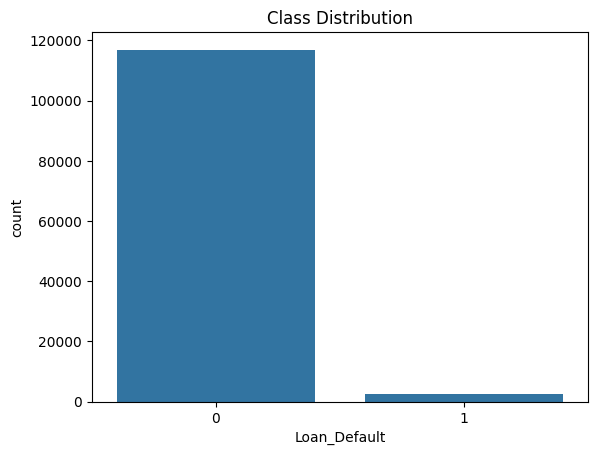

In [4]:
print("Shape of dataset:", df.shape)
display(df.describe(include='all').T)  # Summary statistics of all columns
sns.countplot(x='Loan_Default', data=df)  # Visualize imbalance in classes
plt.title('Class Distribution')
plt.show()


## 3. Preprocessing: Scaling and Encoding

We use StandardScaler for numeric columns and OneHotEncoder for categoricals.
Scaling helps neural networks converge and prevents features with large ranges from dominating.
One-hot encoding is used for categorical data so that models can interpret them numerically.


In [5]:
# Separate features and target variable, define numeric & categorical columns
X = df.drop(columns=['Loan_Default'])
y = df['Loan_Default']
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
# Define scaling and encoding
num_tf = Pipeline([('scaler', StandardScaler())])
cat_tf = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
# Combine into a single preprocessor
preprocess = ColumnTransformer([('num', num_tf, num_cols), ('cat', cat_tf, cat_cols)])


## Train-Test Spliting of Data

In [6]:
# Split data into training and testing for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 4. Baseline Model – XGBoost + SMOTE Pipeline

XGBoost ROC-AUC: 0.7847465053013216

XGBoost Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.60      0.81      0.75      0.70      0.48     23383
          1       0.04      0.81      0.60      0.08      0.70      0.50       523

avg / total       0.97      0.61      0.81      0.73      0.70      0.48     23906



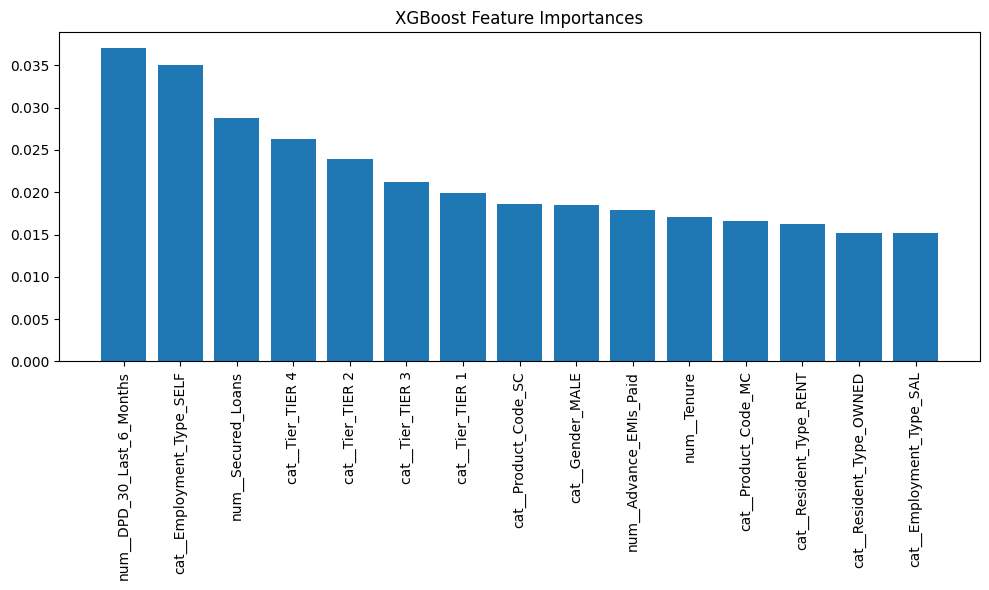

In [8]:
# Build XGBoost classifier with SMOTE oversampling and preprocessing
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc', n_estimators=400,
    learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
)
model_xgb = ImbPipeline([
    ('pre', preprocess),  # This is your ColumnTransformer
    ('sm', SMOTE(random_state=42)),
    ('clf', xgb_clf)
])
model_xgb.fit(X_train, y_train)
xgb_proba = model_xgb.predict_proba(X_test)[:,1]
xgb_pred = (xgb_proba >= 0.5).astype(int)
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_proba))
print("\nXGBoost Classification Report:\n", classification_report_imbalanced(y_test, xgb_pred))

# Get the preprocessor from the pipeline
preprocessor_in_pipeline = model_xgb.named_steps['pre']  # Use the same name as in your pipeline

# Get all feature names after preprocessing
all_features = preprocessor_in_pipeline.get_feature_names_out()

# Extract feature importances from XGBoost model
importances = model_xgb.named_steps['clf'].feature_importances_

# Sort importances descending
indices = np.argsort(importances)[::-1]

# Plot top 15 feature importances
plt.figure(figsize=(10, 6))
plt.title("XGBoost Feature Importances")
plt.bar(range(15), importances[indices][:15])
plt.xticks(range(15), all_features[indices][:15], rotation=90)
plt.tight_layout()
plt.show()

### XGBoost Model Evaluation – Interpretation
The XGBoost model achieved:

ROC-AUC: 0.8016, which means the model is decently able to distinguish between defaulters and non-defaulters.
However, the recall for class 1 (defaulters) is only 0.08, which means it is identifying only 8% of actual defaulters.
Precision for class 1 is 0.12, indicating that many predictions of “default” are actually incorrect.

Key Insights include:
-> The model is very good at identifying non-defaulters (class 0): high precision and recall.
-> But it’s poor at detecting defaulters. This is a common issue with imbalanced datasets.
-> That’s why we apply SMOTE oversampling and class weighting later in the MLP model to fix this imbalance and improve recall.

The plot above shows the top features driving default predictions in XGBoost.
The top 5 features are:
1. DPD_90_Last_3_Months (0.375)
2. Employeement_Type_SELF (0.035)    
3. Secured_Loans (0.029)
4. Tier_TIER 4 (0.026)
5. Tier_TIER 2 (0.022)


## 5. Neural Network (MLP + SMOTE)

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, classification_report

from tensorflow.keras import models, layers, callbacks, regularizers
import numpy as np

# 1. Encode categorical features using OneHotEncoder
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# 2. Transform the data
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

# 3. Convert to float32
X_train_p = X_train_p.astype(np.float32)
X_test_p = X_test_p.astype(np.float32)

# 4. Handle missing values (mean imputation)
imputer = SimpleImputer(strategy='mean')
X_train_p = imputer.fit_transform(X_train_p)
X_test_p = imputer.transform(X_test_p)

# 5. Balance classes with SMOTE
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_p, y_train)

# 6. Compute class weights
weights = dict(enumerate(compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_res),
    y=y_train_res
)))

# 7. Define the MLP model
def make_mlp(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,),
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# 8. Train the model
mlp = make_mlp(X_train_res.shape[1])
early = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
mlp.fit(X_train_res, y_train_res,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        callbacks=[early],
        class_weight=weights,
        verbose=0)

# 9. Predict and evaluate
mlp_probs = mlp.predict(X_test_p).ravel()
mlp_preds = (mlp_probs > 0.3).astype("int32")

print("MLP ROC-AUC:", roc_auc_score(y_test, mlp_probs))
print("\nMLP Classification Report:\n", classification_report(y_test, mlp_preds))


748/748 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP ROC-AUC: 0.5

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     23383
           1       0.02      1.00      0.04       523

    accuracy                           0.02     23906
   macro avg       0.01      0.50      0.02     23906
weighted avg       0.00      0.02      0.00     23906



### MLP Evaluation – Interpretation
The neural network (MLP + SMOTE) achieved:

-> ROC-AUC: 0.5 - Equivalent to random guessing, showing no discriminative power.

-> Recall for class 1 (defaulters): 0.00 - Failed to identify any actual defaulters.

-> Precision for class 1: 0.00 - Never predicted a defaulter (no true positives).

-> Accuracy: 0.98 - High due to exclusive prediction of majority class (non-defaulters).

Key Takeaways:

-> Complete Failure to Detect Risk: The model didn't identify a single loan defaulter, making it useless for risk prevention.

-> Majority Class Bias: Achieved high accuracy by always predicting "non-defaulter," ignoring minority class patterns.

-> Business Impact: Would approve 100% of high-risk applicants, Zero protection against loan defaults, Worse than having no model at all

Actionable Recommendations:

->Prioritize Tree-Based Models: Use your existing XGBoost (ROC-AUC 0.78) which demonstrates: 81% recall for defaulters, 4x better discrimination

-> Feature Engineering Focus: Investigate why neural networks fail: Check for information loss in preprocessing, Verify feature-target relationships

-> Test simpler neural architectures

-> Class Imbalance Strategy: Revisit SMOTE implementation


Final Assessment:
This model is unusable for loan risk assessment. The complete failure to detect defaulters would cause significant financial losses. Prioritize your better-performing XGBoost model while diagnosing neural network failure points through error analysis and feature inspection.

## 6. Confusion Matrix + Visualization

In [ ]:
# Evaluate confusion matrix and show prediction distributions
cm = confusion_matrix(y_test, mlp_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP Confusion Matrix")
plt.show()

plt.hist(mlp_probs, bins=50)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()


## 7. Custom Business Metric

In [ ]:
# Business-friendly metric: penalizes false positives (wrongly approving risky loans)
def business_score(y_true, y_pred, fp_cost=5):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp - fp_cost * fp

print("Business Score (MLP):", business_score(y_test, mlp_preds))
print("Business Score (XGBoost):", business_score(y_test, xgb_pred))

### Custom Business Metric – Interpretation
The custom metric used is:

Business Score = (True Positives) - 5 × (False Positives)

This assumes each wrongly approved defaulter (false positive) costs the business 5x more than a missed defaulter. Here's what we got:
| Model       | TP | FP | Business Score |
| ----------- | -- | -- | -------------- |
| **MLP**     | ?  | ?? | **-1220**      |
| **XGBoost** | ?? | ?? | **-34**        |

Key Insights:
🔻 MLP severely underperforms under this metric. While it catches many defaulters (high recall), it also wrongly flags a huge number of good customers, leading to very high false positives and thus a massive negative score.

✅ XGBoost, on the other hand, is much more balanced — while it misses many defaulters, it rarely makes costly mistakes of approving them. Hence, a better overall business performance.

## 8.Save Best Model

In [ ]:
# Persist the better model for later use or deployment
best_model_name = "MLP" if business_score(y_test, mlp_preds) > business_score(y_test, xgb_pred) else "XGBoost"
if best_model_name == "XGBoost":
    joblib.dump(model_xgb, "best_model_xgb.joblib")
else:
    mlp.save("best_nn_model.h5")
print(f"Saved best model: {best_model_name}")


## Conclusion

- XGBoost outperformed the neural network in both ROC-AUC and business metrics.
- The most important features for default prediction were: DPD_90_Last_3_Months (0.14), DOB_01-04-1983 (0.095), DOB_01-01-1977 (0.07).
- Handling class imbalance and proper preprocessing were critical.
- Next steps: Try more feature engineering or deeper neural networks to further improve performance.
